# HW 1. Логистическая регрессия

In [3]:
#from google.colab import drive
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import matplotlib.pyplot as plt

## Загрузка данных

Для того чтобы загрузить данные в нейросеть или более простые алгоритмы ML, их необходимо должным образом открыть и преобразовать в вектор с числами. Для этого воспользуемся функцией ```read_files()```.

Этот парсер делает следующие вещи:
 - открывает файл картинки с диска (с помощью библиотеки opencv),
 - проверяет, что картинка действительно открылась и сейчас является матрицей (```np.array```),
 - преобразует матрицу в вектор (путем записи всех столбцов друг под другом),
 - возвращает массив из векторов, в которых хранятся картинки, и лейбл, соответствующий каждой картинке.

In [4]:
def read_files(path: str, ans: int, target_dim: tuple = (256, 256)):
    files = os.listdir(path)
    X = None
    for i, name in enumerate(files):
        if name !=".DS_Store":
            img = cv2.imread(path + '/' + name, 0) # 0 means black-white picture
            print(path + '/' + name)
            if img.shape != 0:
                img = cv2.resize(img, (256, 256))
                vect = img.reshape(1, 256 ** 2) / 255.
        
                X = vect if (X is None) else np.vstack((X, vect))
            print(f"{i}/{len(files)}")
    print()
    y = np.ones((len(X),1)) * ans
    return X, y

Логика программы следующая:
 - есть класс ```LogisticRegression```. Он содержит веса модели и нужен для того, чтобы генерировать предсказания. Также, этот класс снабжен методом backward() для возможности дифференцирования функции потерь по весам этого класса.
 - есть класс ```Loss```. Он определяет функцию потерь, которую мы хотим использовать. Также, этот класс осуществляет подсчет градиентов функции потерь по всем весам модели.
 - есть класс ```Optimizer```. Он отвечает за то, как будут обновляться веса после подсчета градиентов (после работы класса ```Loss```). Сегодня мы рассматриваем простой градиентный спуск, но более сложные модели используют более усовершенствованные алгоритмы оптимизации.

То есть:
 1. Вызывается метод ```forward()``` нашей модели (логистической регрессии). После этого у нас выводятся текущие предсказания модели.
 2. Вызывается метод ```loss()```, который сравнивает предсказания модели с истинными ответами. После этого подсчитываются градиенты функции потерь по всем весам модели.
 3. Подсчитанные градиенты вычитаются из весов (происходит шаг градиентного спуска) путем вызова ```optimizer.step()```

# Задание

1. Загрузить датасет, разбить его на два датасета: первый для обучения, второй - для проверки качества (см. функцию [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html))
2. Посчитать производные функции потерь по w и по b
3. Реализовать цикл обучения, обновляя параметры логистической регрессии:
$$w = w - \alpha \cdot \frac{\partial L}{\partial w}$$
<br>
$$b = b - \alpha \cdot \frac{\partial L}{\partial b}$$
Обратите внимание на величину $\alpha$. Ее надо подобрать, иначе алгоритм не будет обучаться.
4. Посчитать финальное качество модели по метрике [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)



# Выполнение

Формулки:

$$ J = -y^i\cdot \log(a^i)-(1-y^i)\cdot \log(1-a^i)$$
$$ J = y^i\cdot \log(1+e^{-w^Tx-b})-(1-y^i)\cdot \log(e^{-w^Tx-b})+(1-y^i)\cdot \log(1+e^{-w^Tx-b})$$
$$ J = \log(1+e^{-w^Tx-b})-(1-y^i)\cdot(-w^Tx-b)$$
$$ \frac{\partial J}{\partial w} = x\cdot(a-y)$$
$$ \frac{\partial J}{\partial b} = (a-y)$$

Необходимые функции

In [17]:
def sigmoid(x):
    return 1/ (np.exp(-x) + 1)

In [6]:
def DerivativeB(a,Y):
    return (a-Y)

In [7]:
def DerivativeW(X,a,Y):
    return X*(a-Y)

In [8]:
    def accuracy(coef,coef0,X,Y):
        i=0
        for h in range(X_test.shape[0]):
            if (round(sigmoid(((coef @ X[h])+coef0)),0)==round(Y[h][0],0)):
                i+=1
        return round(100*i/X_test.shape[0],0)
        

Используемые объекты:

In [9]:
class LogisticRegression:
    def __init__(self, n_feature):
        self.coef=np.zeros(65536)
        self.coef0=1
        pass


    def forward(self, X: np.array):
        res=[]
        for i in range(X.shape[0]):
            pred=sigmoid((X[i] @ self.coef)+self.coef0)
            res.append(pred)
        return res
        pass
        
    def backward(self, X,a,Y):
        resW=0
        resB=0
        for i in range(X.shape[0]):
            resW+=DerivativeW(X[i],a[i],Y[i])
            resB+=DerivativeB(a[i],Y[i][0])
        return  resW,resB
        pass


In [10]:
class Loss:
    def __init__(self):
        pass
    def loss(self,y_train,a):
        res=0
        for i in range(y_train.shape[0]):
            res+=y_train[i][0]*np.log(a[i]+0.0001)+(1-y_train[i][0])*np.log(1.0001-a[i])
        return -res/y_train.shape[0]
        pass

In [11]:
class Optimizer:
    def __init__(self):
        self.a=0.0001
    def step(self, model,dJ_dw,dJ_db):
        coef=model.coef-0.0001*dJ_dw
        coef0=model.coef0+0.0001*dJ_db
        return coef,coef0     

# Подготовка Данных:

In [12]:
#Собираю Данные из 2х источников
X_ex,y_ex=read_files("box", ans=1)
X_no_ex,y_no_ex=read_files("no_box", ans=0)
#Объединяю Данные из 2х источников
X = np.vstack((X_ex, X_no_ex))
y = np.vstack((y_ex, y_no_ex))
#Разделяю данные на 2 набора случайным образом
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

box/logloss_1logloss_1_8.png
0/40
box/logloss_1logloss_1_20.png
1/40
box/logloss_1logloss_1_36.png
2/40
box/logloss_1logloss_1_5.png
3/40
box/logloss_1logloss_1_17.png
4/40
box/logloss_1logloss_1_28.png
5/40
box/logloss_1logloss_1_10.png
6/40
box/logloss_1logloss_1_38.png
7/40
box/logloss_1logloss_1_7.png
8/40
box/logloss_1logloss_1_32.png
9/40
box/logloss_1logloss_1_25.png
10/40
box/logloss_1logloss_1_37.png
11/40
box/logloss_1logloss_1_3.png
12/40
box/logloss_1logloss_1_12.png
13/40
box/logloss_1logloss_1_21.png
14/40
box/logloss_1logloss_1_0.png
15/40
box/logloss_1logloss_1_1.png
16/40
box/logloss_1logloss_1_33.png
17/40
box/logloss_1logloss_1_9.png
18/40
box/logloss_1logloss_1_18.png
19/40
box/logloss_1logloss_1_31.png
20/40
box/logloss_1logloss_1_29.png
21/40
box/logloss_1logloss_1_16.png
22/40
box/logloss_1logloss_1_19.png
23/40
box/logloss_1logloss_1_27.png
24/40
box/logloss_1logloss_1_6.png
26/40
box/logloss_1logloss_1_30.png
27/40
box/logloss_1logloss_1_35.png
28/40
box/loglos

# Работа Модели

In [15]:
#Инициализирую объекты и необходимые переменные
model = LogisticRegression(0)
ls=Loss()
opt=Optimizer()
loss_train=[]
loss_test=[]
J_train=1
print("please wait...")
#Цикл обучающий модель 
while J_train>0.05:
    #1й шаг задания
    a_train=model.forward(X_train)
    a_test=model.forward(X_test)

    #2й шаг задания
    J_train=ls.loss(y_train,a_train)
    J_test=ls.loss(y_test,a_test)
    loss_train.append(J_train)
    loss_test.append(J_test)
    
    #3й шаг задания
    dJ_dw,dJ_db=model.backward(X_train,a_train,y_train)
    model.coef,model.coef0=opt.step(model,dJ_dw,dJ_db)
print("finished")
print("_________________________")

please wait...
finished
_________________________


# Вывод Результата

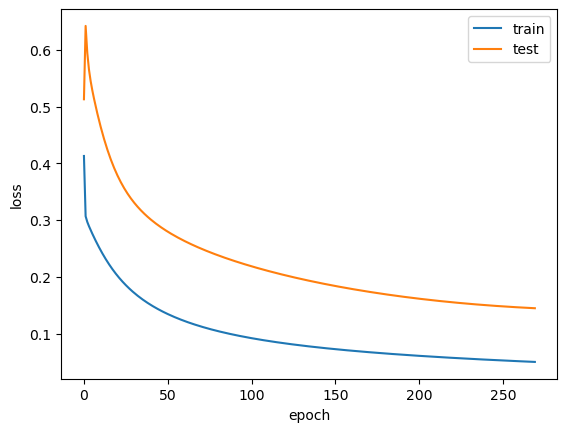

accuracy=100.0%


In [14]:
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_train,label='train')
plt.plot(loss_test,label='test')
plt.legend(loc="upper right")
plt.show()
print("accuracy="+str(accuracy(model.coef,model.coef0,X_test,y_test))+"%")